# Dynamic Job Shop Scheduling: Dispatching Rule

The **job shop scheduling** problem is a classic AI planning, scheduling and combinatorial optimisation problem. It has many real-world applications in Industry 4.0, such as intelligent supply chain management, manufacturing and cloud computing.

In a previous [tutorial](https://github.com/meiyi1986/tutorials/blob/master/job-shop-scheduling-state-space-search.ipynb), we have introduced how to solve job shop scheduling by **state space search** in AI planning. The state space search enumerates all the goal states (complete schedules) to find the best schedule with the minimal makespan.

In most real-world applications, the job shop scheduling problem is **dynamic**. That is, the information for finding the best schedule is not fully known in advance. Some unexpected events can occur in real time when the schedule is being executed. For example, in car manufacturing, we can make a production plan for the coming week (Monday to Friday) based on the orders received by Sunday. However, we might receive new unexpected orders on Tuesday. **Dynamic job shop scheduling** is to find the best schedule over time under dynamic envionment with unexpected/unpredicted events occur in real time.

In this tutorial, we will introduce how to solve dynamic job shop scheduling by the **dispatching rule** heuristic.

## Dynamic Car Manufacturing

Consider the following dynamic car manufacturing scheduling problem. The job shop receives **jobs** to build cars. Each job consists of a **sequence** of three **operations**:

1. **Add Engine**: This is to add the engine to the car by an **Engine Hoist**;
2. **Add Wheels**: This is to add the wheels to the car by a **Wheel Station**;
3. **Inspect**: After the car has been built, it has to be inspected by an **Inspector**.

<img src="img/car-manufacturing.png" width=400 />

At the beginning of the scheduling horizon (i.e., time 0), we have received the following 2 jobs (assuming their arrival time to be 0). 

| Job | Arrival |Operation | Machine |  Duration | 
| --- | ------- | ------- |  --------- | ------ |
| 1   |  0      | `add_engine_1` | `engine_hoist` | 30 |
|     |         | `add_wheels_1` | `wheel_station` | 30 |
|     |         | `inspect_1` |    `inspector` | 10 |  |
| 2   |   0     | `add_engine_2` | `engine_hoist` | 60 |
|     |         | `add_wheels_2` | `wheel_station` | 15 |
|     |         | `inspect_2` |    `inspector` | 10 |

We have found the following best schedule to process these two jobs with a makespan of 115.

<img src="img/schedule1.png" width=600 />

Now we start executing the schedule. However, at time 20, we receive a new job as follows. The dynamic job shop scheduling aims to insert the newly arrived job into the existing schedule in the best way (and **in real time**).

| Job | Arrival |Operation | Machine |  Duration | 
| --- | ------- | ------- |  --------- | ------ |
| 3   |    20   | `add_engine_3` | `engine_hoist` | 20 |
|     |         | `add_wheels_3` | `wheel_station` | 30 |
|     |         | `inspect_3` |    `inspector` | 10 | 

We represent this dynamic job shop scheduling problem with a dynamic job arrivals as follows.

In [4]:
machines = ['engine_hoist', 'wheel_station', 'inspector']

job_1 = {
    'arrival': 0,
    'operations': [
        {'name': 'add_engine_1', 'machine': 'engine_hoist', 'duration': 30, 'next': 'add_wheels_1'},
        {'name': 'add_wheels_1', 'machine': 'wheel_station', 'duration': 30, 'next': 'inspect_1'},
        {'name': 'inspect_1', 'machine': 'inspector', 'duration': 10, 'next': None}
    ]
}

job_2 = {
    'arrival': 0,
    'operations': [
        {'name': 'add_engine_2', 'machine': 'engine_hoist', 'duration': 60, 'next': 'add_wheels_2'},
        {'name': 'add_wheels_2', 'machine': 'wheel_station', 'duration': 15, 'next': 'inspect_2'},
        {'name': 'inspect_2', 'machine': 'inspector', 'duration': 10, 'next': None}
    ]
}
    

job_3 = {
    'arrival': 20,
    'operations': [
        {'name': 'add_engine_3', 'machine': 'engine_hoist', 'duration': 20, 'next': 'add_wheels_3'},
        {'name': 'add_wheels_3', 'machine': 'wheel_station', 'duration': 30, 'next': 'inspect_3'},
        {'name': 'inspect_3', 'machine': 'inspector', 'duration': 10, 'next': None}
    ]
}

jobs = [job_1, job_2, job_3]

## Real-Time Rescheduling



When job 3 arrives at time 20, we can see that `add_engine_1` is already being processed by `engine_hoist`, thus cannot be changed. However, all the other operations are not started yet. Therefore, we can **re-schedule** all the other operations in the existing schedule except `add_engine_1` along with the newly arrived job.

An intuitive and fast way is to directly append the new job to the end of the existing schedule. In this case, we obtain an updated schedule with a makespan of 150.

<img src="img/schedule3.png" width=730 />

However, the best new schedule has a makespan of 135.

<img src="img/rescheduling.png" width=730 />

> **QUESTION**: How to find the best new schedule in real time?

Exhaustive search such as the [state space search](https://github.com/meiyi1986/tutorials/blob/master/job-shop-scheduling-state-space-search.ipynb) can guarantee to find the best schedule. However, their computational complexity is often too high, and cannot respond to the dynamic environment efficiently.

> **NOTE**: As shown in the previous [tutorial](https://github.com/meiyi1986/tutorials/blob/master/job-shop-scheduling-state-space-search.ipynb), the complexity of the state space search is $O(N^{NM})$, where $N$ is the number of jobs and $M$ is the number of machines. If there are 5 jobs and 5 machines, the complexity will be up to $5^{5\times 5} \approx 3 \times 10^{17}$.

<!-- On the other hand, in the dynamic environment, we need to make decisions in a very short time. In this case, we need to decide the next operation for `engine_hoist` before it becomes idle again at time 30. The state space search is often too slow to respond for dynamic job shop scheduling. -->

To address issue, we can use **dispatching rule**, which can **make decisions in real time**.

## Dispatching Rule <a name='rule'></a>

In contrast with the state space search that expands all the applicable actions at each state, dispatching rule expands **only one** action at each state. As shown in the following car manufacturing state space, dispatching rule selects one branch (highlighted in blue boxes) at each state and finally reach a single goal state (a leaf node in the search tree).

<img src="img/jss-rule-search.png" width=600 />

A dispatching rule selects the single action from the applicable actions based on the following two steps.

1. Select the **earliest** applicable action (with the smallest start time).
2. If there are multiple earliest applicable actions, then select an action based on the predefined **priority function**. Specifically, for each earliest applicable actions, a priority value in the current state is calculated by the priority function. Then, the action with the **highest priority** is selected.

The pseudo code of the dispatching rule heuristic is described as follows.

```python
Create an initial state
# Initialise the fringe with the initial state
fringe = [initial_state]

# Search process, the fringe will become empty after the first and only goal state is reached
while fringe is not empty:
    # Select the first and only state in the fringe
    state = fringe[0]
    
    if state is a goal state:
        return schedule of state
    
    Find the applicable actions at state
    
    # Select the earliest action with the highest priority
    best_action = None, earliest_time = float('inf'), best_priority = -float('inf')
    for action in applicable_actions:
        if action.time < earliest_time:
            best_action = action, earliest_time = action.time, best_priority = priority(action, state)
        elif action.time == earliest_time:  
            p = priority(action, state)
            if p > best_priority:
                best_action = action, best_priority = p
    
    Apply best_action to state to create next_state
    Add next_state into fringe

    remove state from fringe
```

Below are some examples of commonly used dispatching rules.

- **First-Come-First-Serve (FCFS)**: it processes the operation that comes to the machine (becomes ready) first. The priority function can be defined as the negative ready time of the processed operation, i.e., `priority(action, state) = - state.operation_ready_time[action.operation]`.
- **Shortest-Processing-Time (SPT)**: it processes the shortest operation with the smallest processing time first. The priority function can be defined as the negative processing time, i.e., `priority(action, state) = - action.operation.duration`.

When solving dynamic job shop scheduling by dispatching rule, we first create the initial state as follows. Different from the static job shop scheduling, the first operation of each job is **ready at the job arrival time** rather than 0.

In [9]:
def create_init_state(machines, jobs):
    init_state = {
        "machine_idle_time": {},
        "operation_ready_time": {},
        "schedule": {},
        "completed": [] # no operation is completed initially
    }

    # Initially, the idle time of all the machines are 0.
    for m in machines:
        init_state["machine_idle_time"][m] = 0

    # Initially, only the first operation of each job is ready at the job arrival time
    for job in jobs:
        first_op = job['operations'][0]
        init_state["operation_ready_time"][first_op["name"]] = job['arrival']

    # Initially, the machine schedules are empty
    for m in machines:
        init_state["schedule"][m] = []
    
    return init_state

Then, we implement the dispatching rule search algorithm as follows, where `priority` is the priority function used by the dispatching rule.

In [34]:
def dispatching_rule_search(machines, jobs, priority):
    # Create the operation dictionary for state space search
    operations = {}
    for job in jobs:
        for op in job['operations']:
            operations[op['name']] = op

    # Create the initial state
    state = create_init_state(machines, jobs)

    # Search until reaching a goal state
    while len(state["completed"]) < len(operations):
        # Find the best action by a dispatching rule (priority function).
        # First, find the earliest applicable action.
        # Then, if there are multiple exist, select the one with the highest priority.
        
        best_action = None
        earliest_time = float('inf')
        best_priority = -float('inf')
        for opname in state["operation_ready_time"].keys():
            op = operations[opname]
            machine = op['machine']        
            time = state["operation_ready_time"][opname]
            if time < state["machine_idle_time"][machine]:
                time = state["machine_idle_time"][machine]
            
            if time < earliest_time:
                best_action = (op, time)
                earliest_time = time
                best_priority = priority(best_action, state)
            elif time == earliest_time:
                p = priority((op, time), state)
                if p > best_priority:
                    best_action = (op, time)
                    best_priority = p

        # Apply the best action to the state        
        op = best_action[0] # action operation
        machine = op['machine'] # action machine
        time = best_action[1] # action start time
        finish_time = time + op['duration'] # action finish time

        # Apply the action to the current state, create the next state
        state["schedule"][machine].append(best_action) # add action to corresponding machine schedule sequence
        state["completed"].append(op['name']) # add operation name to completed
        state["operation_ready_time"].pop(op['name']) # delete completed operation name from ready time
        state["machine_idle_time"][machine] = finish_time # machine will become idle after completion

        # If the operation is not the last operation of the job, then its next operation becomes ready
        if op['next'] != None:
            next_op = operations[op['next']]
            state["operation_ready_time"][next_op['name']] = finish_time
    
    return state["schedule"]

Now, we can generate a schedule by the **shortest processing time (SPT)** rule.

In [39]:
# Define the priority function of the SPT rule: priority = - duration
spt_rule = lambda action, state: -action[0]['duration']
# Generate a schedule by the SPT rule
spt_schedule = dispatching_rule_search(machines, jobs, spt_rule)

For displaying the schedule, we copy the functions to plot the gantt chart of schedule from the previous [tutorial](https://github.com/meiyi1986/tutorials/blob/master/job-shop-scheduling-state-space-search.ipynb).

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Convert schedule into DataFrame
def schedule_data_frame(schedule):
    schedule_dict = []
    for machine_schedule in schedule.values():
        for action in machine_schedule:
            a_dict = {
                'Operation': action[0]['name'],
                'Machine': action[0]['machine'],
                'Start': action[1],
                'Duration': action[0]['duration'],
                'Finish': action[1] + action[0]['duration']
            }
            schedule_dict.append(a_dict)
    
    return pd.DataFrame(schedule_dict)

# Plot gantt chart from schedule
def gantt_chart(schedule):
    schedule = schedule_data_frame(schedule)
    
    JOBS = sorted(list(schedule['Operation'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Operation', 'Start'])
    schedule.set_index(['Operation', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Operation')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

We plot the gantt chart of the schedule obtained by the SPT rule as follows. We can see its makespan is 135.

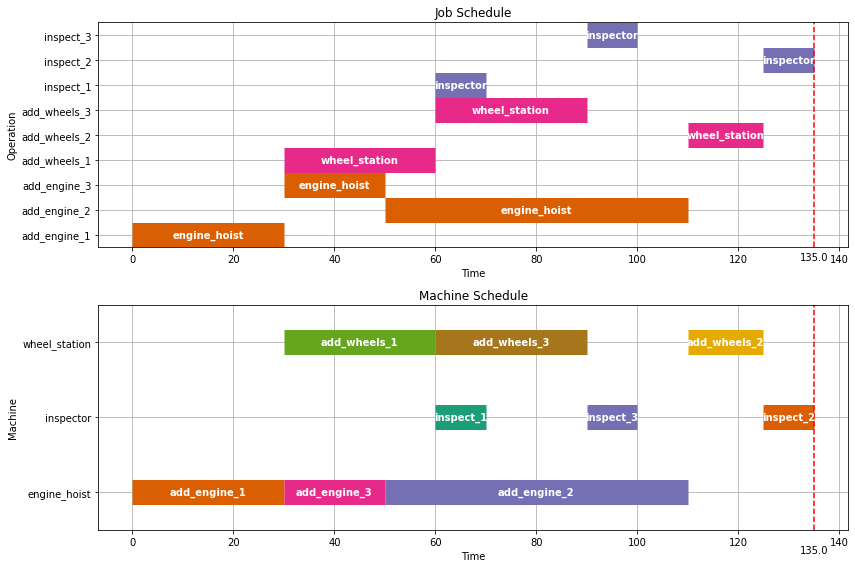

In [37]:
gantt_chart(spt_schedule)

Below we show the gantt chart of the schedule obtained by the **First Come First Serve (FCFS)** rule, whose priority function is `- operation ready time`. 

In [40]:
fcfs_rule = lambda action, state: -state['operation_ready_time'][action[0]['name']]
fcfs_schedule = dispatching_rule_search(machines, jobs, fcfs_rule)
gant(fcfs_schedule)

NameError: name 'heuristic_search_dispatching_rule' is not defined

In comparison, we can see that the Shortest Processing Time rule processes `job_3` before `job_2`, since its first operation `add_engine_3` is shorter than `add_engine_2` when the `engine_hoist` machine becomes ready at time 30. However, the First Come First Serve rule processes `add_engine_2` before `add_engine_3` at time 30, since `job_2` arrives earlier than `job_3`. The long `add_engine_2` causes delay of the subsequent operations, and ultimately leads to larger makespan of the schedule.

--------

### Computational Complexity

Assume that there are $N$ jobs and $M$ machines. Each job has $M$ operations, each to be processed by a different machine. There are $NM$ operations in total.

At each state, there can be at most $N$ applicable actions, as each job can have an operation ready. Therefore, it takes $O(N)$ time to find the best action from the $N$ applicable actions. However, only one branch is expanded.

Each action completes an operation. Thus, it takes $NM$ actions from the initial state to a goal state. In other words, the depth of the tree is $NM$.

In summary, a dispatching rule generates a chain-like search tree where each node has only one branch expanded. The entire search process visits $NM$ states, where each state takes $O(N)$ time to find the expanded branch. Therefore, the overall complexity of the dispatching rule-based heuristic search is $O(N^2M)$.

> Dispatching rule has a promising characteristic that it always expends an earliest action. Taking advantage of this characteristic, we can convert the above procedure into a much more efficient **discrete event simulation** procedure with priority queue. Then, for each state, we can obtain the earliest applicable actions in $O(1)$ time. In this case, we can find the best branch in $O(E)$ time, where $E$ is the number of earliest applicable action, which is usually much smaller than $N$. We can see that the **discrete event simulation** can greatly reduce the computational complexity to $O(NME) \ll O(N^2M)$.

- More tutorials can be found [here](https://github.com/meiyi1986/tutorials).
- [Yi Mei's homepage](https://meiyi1986.github.io/)